# Global code for all baselines

In [2]:
from __future__ import division
import numpy as np
import ijson
import pickle
import os
import jsonReader
from haversine import haversine
from math import floor

#Need to:
        #0. Scan the file when producing metadata and create a list of data point indices
        #1. Load the list of data point indices
        #2. Randomly permute the list of data point indices
        #3. Split the list of data point indices into training, validation, and test sets
        #4. Provide a method to get the next data point in the list (and either globally save the position of the list or save it implicitly in a generator)
        #5. Provide a method to reset this list position (for a new epoch)
        #6. Rewrite the endoIterator method to respect randomization (copy the random access iterator code from the ptb reader example)

class dataInterpreter(object):
    def __init__(self, fn="endomondoHR_proper.json", attributes=None, allowMissingData=True, scaleVals=True, excisedFN = "excisedData_auto_nohup.p", trimmed_workout_length=500):
        self.dataFileName=fn#Will eventually replace this with a data folder name
        self.dataFile=open(self.dataFileName, 'r')
        self.MetaDataLoaded=False
        self.dataSchemaLoaded=False
        #self.currentDataPoint=None
        self.dataPointPosition=0
        self.attIgnore=['id','url','speed']#Attributes to ignore when building metadata
        self.metaDataFn=fn[0:len(fn)-5]+"_metaData.p"
        self.allowMissingData=allowMissingData
        self.scaleVals=scaleVals
        #self.valTestSplit=(.1,.1)
        self.excisedFN = excisedFN
        self.trimmed_workout_length = trimmed_workout_length
        self.m_smooth_window = 1
        self.perform_target_smoothing = True
        #if attributes is not None:
        #    self.buildDataSchema(attributes)
    
    def buildDataSchema(self, attributes, targetAtt, trainValTestSplit=(.8,.1,.1), zMultiple = 2):
        self.targetAtt=targetAtt
        self.buildMetaData()
        self.trainValTestSplit = trainValTestSplit
        self.splitForValidation(trainValTestSplit)
        #self.newEpoch()#Reset all indices and counters
        self.attributes=attributes
        self.zMultiple = zMultiple
        dataDimSum=0
        for att in self.attributes:
            dataDimSum=dataDimSum+self.encodingLengths[att]
        self.dataDim=dataDimSum
        
        #Create a dictionary that takes an attribute and returns a beginning and end position of the attribute in the input sequence
        self.inputAttributes =[x for x in self.attributes if x != targetAtt]
        self.inputIndices={}
        lastIndex=0
        for att in self.inputAttributes:
            nextIndex=lastIndex+self.encodingLengths[att]
            self.inputIndices[att]=(lastIndex, nextIndex)
            lastIndex=nextIndex
            
        self.dataSchemaLoaded=True
    
    def createSequentialGenerator(self): #Define a new data generator
        filename = self.dataFileName
        self.f=open(filename, 'r')
        objects = ijson.items(self.f, 'users.item')
        self.dataObjects=objects
        return self.dataObjects
    
    def dataGenerator(self, dataSetOrder):
        for dp_index in dataSetOrder:
            fileIndices = self.dataPointIndices[dp_index]
            potentialNextDataPoint=jsonReader.getDataPoint(fileIndices, self.dataFile)
            
            """
            if self.allowMissingData==False:
                #Check if the next data point contains all the requested attributes
                for i, att in enumerate(self.attributes):
                    #print(att)
                    try:
                        test=self.currentDataPoint[att]
                    except:
                        print("Skipping data point because it lacks attribute: " + att)
                        #print("Skipping data point because it lacks attribute")
                        return self.getNextDataPoint() #Try the next one instead
            """
            yield potentialNextDataPoint #returns next data point
    
    def randomizeDataOrder(self, dataIndices):
        return np.random.permutation(dataIndices)

    #def getNextDataPoint(self):
    #        jsonReader.getDataPoint(index, dataFile)
    #    return dataPoint

    def getNextDataPointSequential(self):
        try: #If there is a generator already defined
            objects=self.dataObjects
        except: #Otherwise create a new one
            #Creating new generator
            objects=self.createSequentialGenerator()
        nextDataPoint=self.__convert(objects.next())

        return nextDataPoint
    
    #def newEpoch(self):
        # A convenience function for reseting the data loader to start a new epoch
        #self.currentDataPoint = None
    #    self.dataPointPosition = 0  # The position within a data point (within an exercise)       
    

    def dataIteratorSupervised(self, trainValidTest):
        targetAtt=self.targetAtt
        #Performs the same job as the batch iterator, but with one of the attributes separated as the supervision signal
        inputAttributes = self.inputAttributes
        inputDataDim=self.getInputDim(targetAtt)
        targetDataDim=self.getTargetDim(targetAtt)

        if trainValidTest == 'train':
            self.trainingOrder = self.randomizeDataOrder(self.trainingSet)
            dataGen = self.dataGenerator(self.trainingOrder)
        elif trainValidTest == 'valid':
            self.validationOrder = self.randomizeDataOrder(self.validationSet)
            dataGen = self.dataGenerator(self.validationOrder)
        elif trainValidTest == 'test':
            self.testOrder = self.randomizeDataOrder(self.testSet)
            dataGen = self.dataGenerator(self.testOrder)
        else:
            raise (Exception("Invalid dataset type. Must be 'train', 'valid', or 'test'"))

        if self.dataSchemaLoaded == False:
            raise (RuntimeError("Need to load a data schema"))

        #inputData = np.zeros((batch_size, inputDataDim))
        # inputDataDim is the total concatenated length of the data at each time point (for all input attributes)
        #targetData = np.zeros((batch_size, targetDataDim))

        for currentDataPoint in dataGen:
            currentDerivedData = {} #Reset the derived data dictionary
            smoothedData = {}
            for dataPointPosition in range(self.trimmed_workout_length):
                dataList = []  # A mutable data structure to allow us to construct the data instance...
                for j, att in enumerate(inputAttributes):
                    if self.isDerived[att]:
                        #handle the derived variables
                        if att in currentDerivedData.keys():
                            #Use the data from the current data point position
                            attData = currentDerivedData[att][dataPointPosition]
                        else:
                            #Generate the data and then use the data from the current data point position which should be 0
                            currentDerivedData[att] = self.deriveData(att, currentDataPoint)
                            attData = currentDerivedData[att][dataPointPosition]
                    else:
                        if self.isSequence[att]:  # Need to limit the sequence to the end of the batch...
                            # Put the sequence attributes in their proper positions in the tensor array
                            # These are numeric encoding schemes.
                            attData = float(currentDataPoint[att][dataPointPosition])  # Get the next entry in the attribute sequence for the current data point
                        else:
                            # Put the context attributes in their proper positions in the tensor array
                            # These are a one-hot encoding schemes except in the case of "age" and the like
                            if self.isNominal[att]:  # Checks whether the data is nominal
                                attData = self.oneHot(currentDataPoint, att)  # returns a list
                            else:
                                attData = currentDataPoint[att]  # Handles ordinal and numeric data

                    scaledAttData = self.scaleData(attData, att, self.zMultiple)  # Rescales data if needed
                    if self.isList(scaledAttData):
                        dataList.extend(scaledAttData)
                    else:
                        dataList.append(scaledAttData)
                #Now do the same for the target attribute
                if self.isSequence[targetAtt]:  # Need to limit the sequence to the end of the batch...
                    # Put the target attribute in its proper positions in the tensor array
                    # These are numeric encoding schemes.
                    if self.isDerived[targetAtt]:
                        if targetAtt in currentDerivedData.keys():
                            #Use the data from the current data point position
                            attTarData = currentDerivedData[targetAtt][dataPointPosition]
                        else:
                            #Generate the data and then use the data from the current data point position which should be 0
                            temp_derived_tar_data = self.deriveData(targetAtt, currentDataPoint)
                            if self.perform_target_smoothing:
                                smoothed_derived_tar_data = self.median_smoothing(temp_derived_tar_data, self.m_smooth_window)
                                currentDerivedData[targetAtt] = smoothed_derived_tar_data
                            else:
                                currentDerivedData[targetAtt] = temp_derived_tar_data
                            attTarData = currentDerivedData[targetAtt][dataPointPosition]
                    else:
                        if self.perform_target_smoothing:
                            if targetAtt in smoothedData.keys():
                                attTarData = float(smoothedData[targetAtt][dataPointPosition])
                            else:
                                smoothedData[targetAtt] = self.median_smoothing(currentDataPoint[targetAtt], self.m_smooth_window)
                                attTarData = float(smoothedData[targetAtt][dataPointPosition])
                        else:
                            attTarData = float(currentDataPoint[targetAtt][dataPointPosition])  # Get the next entry in the attribute sequence for the current data point
                else:
                    # Put the context attributes in their proper positions in the tensor array
                    # These are a one-hot encoding schemes except in the case of "age" and the like
                    if self.isNominal[targetAtt]:  # Checks whether the data is nominal
                        attTarData = self.oneHot(currentDataPoint, targetAtt)  # returns a list
                    else:
                        attTarData = currentDataPoint[targetAtt]  # Handles ordinal and numeric data

                scaledTargetAttData = self.scaleData(attTarData, targetAtt, self.zMultiple)  # Rescales data if needed
                targetData = [] #So that we can return it in the same list format as the inputs
                targetData.append(scaledTargetAttData)#Add the target data for the current data point to the full list

                #Check length of input data vector
                if len(dataList) == inputDataDim:
                    inputData = dataList
                else:
                    print("Data list length: " + str(len(dataList)))
                    print("Data schema length: " + str(len(inputDataDim)))
                    raise(ValueError("Data is not formatted according to the schema"))

                yield [inputData, targetData]

    def endoIteratorSupervised(self, batch_size, num_steps, trainValidTest):
            #Does the same thing as the endoIterator, except for a model with separate supervised targets (targets are not the next element in the sequence)

            batchGen = self.dataIteratorSupervised(trainValidTest)
            
            if trainValidTest=="train":
                set_size_multiple=self.trainValTestSplit[0]
            elif trainValidTest=="valid":
                set_size_multiple=self.trainValTestSplit[1]
            elif trainValidTest=="test":
                set_size_multiple=self.trainValTestSplit[2]
            else:
                raise(ValueError("trainValidTest is not a valid value"))
            

            data_len = self.numDataPoints*self.trimmed_workout_length*set_size_multiple
            batch_len = data_len / batch_size
            epoch_size = int(floor(batch_len / num_steps))

            inputDataDim = self.getInputDim(self.targetAtt)
            targetDataDim = self.getTargetDim(self.targetAtt)

            if epoch_size == 0:
                raise ValueError("epoch_size == 0, decrease batch_size or num_steps")
                

            #nextRow=[next(batchGen) for x in range(num_steps)]#Fill the first row (with both inputs and targets)
            #print(nextRowTargets)
            for i in range(epoch_size):
                inputData = np.zeros([batch_size, num_steps, inputDataDim])
                targetData = np.zeros([batch_size, num_steps, targetDataDim])
                for j in range(batch_size):
                    for k in range(num_steps):
                        currentTimePoint = batchGen.next()
                        inputData[j,k,:] = currentTimePoint[0]
                        targetData[j,k,:] = currentTimePoint[1]

                x = inputData
                y = targetData
                yield (x, y)
    
    def generator_for_autotrain(self, batch_size, num_steps, trainValidTest, epoch_size_limit = None):
            #For use with Keras' fit_generator method (automatically resets)
            #The epoch_zie paramater allows you to manually set an epoch size parameter instead of using the full data set and then restarting
            while True:
                print("Starting New Generator Epoch: "+trainValidTest)
                dGen=self.endoIteratorSupervised(batch_size, num_steps, trainValidTest)
                if epoch_size_limit is not None:
                    for i in range(epoch_size_limit):
                        x, y = dGen.next()
                        yield(x,y)
                else:
                    for x, y in dGen:
                        yield(x,y)
    
    def splitForValidation(self, valTestSplit):
        #Construct seperate data files for the training, test, and validation data
        
        #First excise the excised list
        self.excisedList = self.loadExcisedList(self.excisedFN)
        self.unalteredNumDPs = self.numDataPoints
        self.numDataPoints = self.unalteredNumDPs-len(self.excisedList)
        excisedSet = set(self.excisedList)
        self.dataPointList = [x for x in range(self.unalteredNumDPs) if x not in excisedSet]
        print("Number of data points: " + str(self.numDataPoints))
        
        trainingSetSize=int(floor(self.numDataPoints*valTestSplit[0]))
        validationSetSize=int(floor(self.numDataPoints*valTestSplit[1]))
        testSetSize=int(floor(self.numDataPoints*valTestSplit[2]))
        randomOrderedDataList=self.randomizeDataOrder(self.dataPointList)
        
        self.trainingSet=randomOrderedDataList[0:trainingSetSize]
        self.validationSet=randomOrderedDataList[trainingSetSize:trainingSetSize+validationSetSize]
        self.testSet=randomOrderedDataList[trainingSetSize+validationSetSize:trainingSetSize+validationSetSize+testSetSize]
        
        #print("training set size:" + str(len(self.trainingSet))
        #print("validation set size:" + str(len(self.validationSet))
        #print("test set size:" + str(len(self.testSet)))
        
    def loadExcisedList(self, excisedFN):
        with open(excisedFN, "rb") as f:
            exc_l = pickle.load(f)
        return exc_l
    
    def decoderKey(self):
        return [x for x in self.attributes if x != targetAtt]
    
    def dataDecoder(self, dataPoints):
        convertedData=[]
        for dp in dataPoints:
            convertedData.append(self.dataDecoderDP(dp))
        return convertedData
    
    def dataDecoderDP(self, dataPoint):
        #This function takes an encoded data point (a single time step) and decodes it into a readable set of variables 
        #for use in statistical processing and visualization
        inputAttributes = [x for x in self.attributes if x != self.targetAtt]
        #inputDataDim=self.getInputDim(inputAttributes)
        
        try:
            inverseEncoders=self.inverseOneHotEncoders
        except:
            self.inverseOneHotEncoders=self.invertOneHots()
            inverseEncoders=self.inverseOneHotEncoders
        
        decodedDataPoint=[]
        dataPointPosition=0
        for i, att in enumerate(inputAttributes):
            attLength = self.encodingLengths[att]
            currentAttData = dataPoint[dataPointPosition:dataPointPosition+attLength]
            dataPointPosition = dataPointPosition + attLength
            if self.isSequence[att]==False:
                currentEncoder=inverseEncoders[att]
                decodedDataPoint.append(currentEncoder[str([int(i) for i in list(currentAttData)])])
            else:
                decodedDataPoint.append(currentAttData[0])

        return decodedDataPoint

    def deriveData(self, att, currentDataPoint):
        if att=='time_elapsed':
            #Derive the time elapsed data sequence
            timestamps=currentDataPoint['timestamp']
            initialTime=timestamps[0]
            return [x-initialTime for x in timestamps]
            #Going to need to scale these appropriately in the scaling function
        elif att=='distance':
            #Derive the distance data sequence
            lats=currentDataPoint['latitude']
            longs=currentDataPoint['longitude']
            indices=range(1, len(lats)) #Creates a list of indices from 1 to the length of the seuqnces to index all elements but the first (element zero)
            distances=[0]
            distances.extend([haversine([lats[i-1],longs[i-1]], [lats[i],longs[i]]) for i in indices]) #Gets distance traveled since last time point in kilometers
            return distances
        elif att=='new_workout':
            workoutLength=self.trimmed_workout_length
            newWorkout=np.zeros(workoutLength)
            newWorkout[0]=1 #Add the signal
            return newWorkout
        elif att=='derived_speed':
            distances=self.deriveData('distance', currentDataPoint)
            timestamps=currentDataPoint['timestamp']
            indices=range(1, len(timestamps))
            times=[0]
            times.extend([timestamps[i] - timestamps[i-1] for i in indices])
            derivedSpeeds=[0]
            try:
                derivedSpeeds.extend([distances[i]/times[i] for i in indices])
            except:
                #print("Exception in deriving speeds")
                for i in indices:
                    try:
                        derivedSpeeds.append(distances[i]/times[i])
                    except:
                        derivedSpeeds.append(0)
            return derivedSpeeds
        else:
            raise(Exception("No such derived data attribute"))

        
    def scaleData(self, data, att, zMultiple=2):
        #This function scales the data based on precomputed means and standard deviations
        #It does this by computing z-scores and multiplying them based on a scaling paramater
        #It therefore produces zero-centered data, which is important for the drop-in procedure
        if self.scaleVals:
            if self.isSequence[att]:
                diff = data-float(self.variableMeans[att])
                zScore = diff/float(self.variableStds[att])
                return zScore * zMultiple
            else:
                return data
        else:
            return data

    def median_smoothing(self, seq, context_size):
        #Perform fixed-window median smoothing on a sequence

        if context_size==1: #If the window is 1, no smoothing should be applied
            return seq

        seq_len = len(seq)

        if context_size%2==0:
            raise(exception("Context size must be odd for median smoothing"))

        smoothed_seq = []
        for i in range(seq_len):
            cont_diff = (context_size-1)/2
            context_min = int(max(0, i-cont_diff))
            context_max = int(min(seq_len, i+cont_diff))
            median_val = np.median(seq[context_min:context_max])
            smoothed_seq.append(median_val)

        return smoothed_seq
        
    def __convert(self, unicData): #Converts the unicode text in a dictionary to ascii
        #Shamelessly lifted from http://stackoverflow.com/questions/13101653/python-convert-complex-dictionary-of-strings-from-unicode-to-ascii
        if isinstance(unicData, dict):
            return {self.__convert(key): self.__convert(value) for key, value in unicData.iteritems()}
        elif isinstance(unicData, list):
            return [self.__convert(element) for element in unicData]
        elif isinstance(unicData, unicode):
            return unicData.encode('utf-8')
        else:
            return unicData
        
    def getDataPointLength(self, dataPoint):
        #Checks a single attribute. If the length of all sequence attributes is not equal, additional code will need to be written...
        return len(dataPoint["heart_rate"])#tries "heart_rate"
    
    def isList(self, attData):
        #checks whether the variable attData is a list and returns true or false
        return isinstance(attData, list)
        #might want to try isSubclass(attData, list) if this doesn't work...
    
    def buildEncoder(self, classLabels):
        #Constructs a dictionary that maps each class label to a list (encoding scheme) where one entry in the list is 1 and the remainder are 0
        encodingLength=classLabels.size
        encoder={}
        for i, label in enumerate(classLabels):
            encoding=[0] * encodingLength
            encoding[i]=1
            encoder[label]=encoding
        return encoder
    
    def getDataLabels(self, data, dataClass):
        #The "data" argument is in the same format as is returned by "getNdatapoints"
        #If there is a use case that involves finding all the possible labels for a given class, a seperate function should be written to save memory usage...
        class_labels = [col[dataClass] for col in data]
        return np.unique(np.array(class_labels))
    
    def writeSummaryFile(self):
        metaDataForWriting=metaDataEndomondo(self.numDataPoints, self.encodingLengths, self.oneHotEncoders, self.isSequence, 
                                             self.isNominal, self.isDerived, self.dataPointIndices, self.variableMeans, self.variableStds)
        with open(self.metaDataFn, "wb") as f:
            pickle.dump(metaDataForWriting, f)

        #pickle.dump(metaDataForWriting, open(self.metaDataFn, "wb"))
        print("Summary file written")
        
    def loadSummaryFile(self):
        try:
            print("Loading metadata")
            with open(self.metaDataFn, "rb") as f:
                metaData = pickle.load(f)
                
            #metaData=pickle.load(open(self.metaDataFn, "rb"))
        except:
            raise(IOError("Metadata file: " + self.metaDataFn + " not in valid pickle format"))
        self.numDataPoints=metaData.numDataPoints
        self.encodingLengths=metaData.encodingLengths
        self.oneHotEncoders=metaData.oneHotEncoders
        #self.dataDim=metaData.dataDim
        self.isSequence=metaData.isSequence
        self.isNominal=metaData.isNominal
        self.isDerived=metaData.isDerived
        self.dataPointIndices=metaData.dataPointIndices
        self.variableMeans = metaData.variableMeans
        self.variableStds = metaData.variableStds
        print("Metadata loaded")
        
    def buildMetaData(self):
        #Takes a list of attributes and the current datafile and constructs a schema for the data to be input into the RNN.
        if os.path.isfile(self.metaDataFn):#If a summary file exists
            self.loadSummaryFile()#Load that summary file and use it to capture all the necessary info
        else:
            print("Building data schema")
            #Build such a summary file by running through the full dataset and capturing the necessary statistics
            self.isSequence={'altitude':True, 'gender':False, 'heart_rate':True, 'id':False, 'latitude':True, 'longitude':True,
                             'speed':True, 'sport':False, 'timestamp':True, 'url':False, 'userId':False, 'time_elapsed': True, 
                             'distance':True, 'new_workout':True, 'derived_speed':True}#Handcoded
            self.isNominal={'altitude':False, 'gender':True, 'heart_rate':False, 'id':True, 'latitude':False, 'longitude':False,
                            'speed':False, 'sport':True, 'timestamp':False, 'url':True, 'userId':True, 'time_elapsed': False,
                            'distance':False, 'new_workout':False, 'derived_speed':False}#Handcoded
            self.isDerived={'altitude':False, 'gender':False, 'heart_rate':False, 'id':False, 'latitude':False, 'longitude':False,'speed':False, 'sport':False, 'timestamp':False, 'url':False, 'userId':False, 'time_elapsed': True, 'distance':True, 'new_workout':True, 'derived_speed':True}#Handcoded
            allAttributes=['altitude', 'gender', 'heart_rate', 'id', 'latitude', 'longitude',
                   'speed', 'sport', 'timestamp', 'url', 'userId', 'time_elapsed', 'distance', 'new_workout', 'derived_speed']
            attributes=[x for x in allAttributes if x not in self.attIgnore]#get rid of the attributes that we are ignoring
            
            variableSums={'altitude':0, 'gender':0, 'heart_rate':0, 'id':0, 'latitude':0, 'longitude':0,
                   'speed':0, 'sport':0, 'timestamp':0, 'url':0, 'userId':0, 'time_elapsed': 0,
                            'distance':0, 'new_workout':0, 'derived_speed':0}
            
            excisedList = self.loadExcisedList(self.excisedFN)
            excisedSet = set(excisedList)
            
            #self.newEpoch()#makes sure to reset things
            moreData=True
            classLabels={}
            numDataPoints=0
            while moreData:
                if numDataPoints%1000==0:
                    print("Currently at data point " + str(numDataPoints))
                try:
                    currData=[self.getNextDataPointSequential()]
                    #dataClasses = self.getDataClasses(currData)#This could be removed to make it more effecient
                    if numDataPoints in excisedSet:
                        numDataPoints += 1
                        pass
                    else:
                        for att in attributes:
                            if self.isDerived[att] != True:
                                if self.isNominal[att]: #If it is nominal data
                                    if self.isSequence[att]:
                                        raise(NotImplementedError("Nominal data types for sequences have not yet been implemented"))
                                    dataClassLabels=self.getDataLabels(currData, att)
                                    if classLabels.get(att) is None: #If it is the first step
                                        classLabels[att]=dataClassLabels
                                    else:
                                        #print(np.concatenate(dataClassLabels,classLabels[datclass]))
                                        #This line is probably taking up all of the time...
                                        if dataClassLabels not in classLabels[att]:
                                            #print(dataClassLabels)
                                            classLabels[att]=np.unique(np.concatenate([dataClassLabels, classLabels[att]]))
                                else:
                                    if self.isSequence[att]!=True:
                                        #If is it nominal and not a sequence
                                        raise(NotImplementedError("Non-nominal data types for non-sequences have not yet been implemented"))
                                    else:
                                        #Add to the variable running sum
                                        tempData = currData[0]
                                        #print(tempData.keys)
                                        variableSums[att] += sum(tempData[att])
                            else:
                                #Handle the derived variables
                                currentDerivedData = self.deriveData(att, currData[0])
                                variableSums[att] += sum(currentDerivedData)

                        numDataPoints += 1
                except:
                    moreData=False
                    print("Stopped at " + str(numDataPoints) + " data points")
            
            oneHotEncoders={}
            encodingLengths={}
            dataDim=0
            for att in attributes:
                if self.isSequence[att]==False:
                    oneHotEncoders[att]=self.buildEncoder(classLabels[att])
                    encodingLengths[att]=classLabels[att].size
                    #dataDim=dataDim+encodingLengths[datclass]
                else:
                    if self.isNominal[att]:
                        raise(NotImplementedError("Nominal data types for sequences have not yet been implemented"))
                    else:
                        encodingLengths[att]=1
                        #dataDim=dataDim+1
            print("Getting data indices")
            dataPointIndices=jsonReader.getDataIndices(self.dataFileName)
            
            #Set all of the summary information to self properties
            self.computeMeansStandardDeviations(variableSums, numDataPoints, attributes)
            self.numDataPoints=numDataPoints
            self.encodingLengths=encodingLengths#A dictionary that maps attributes to the lengths of their vector encoding schemes
            self.oneHotEncoders=oneHotEncoders#A dictionary of dictionaries where the outer dictionary maps attributes to encoding schemes and where each encoding scheme is a dictionary that maps attribute values to one hot encodings
            #self.dataDim=dataDim#The sum of all the encoding lengths for the relevant attributes
            #self.isSequence=#A dictionary that returns whether an attribute takes the form of a sequence of data
            #self.isNominal=#A dictionary that returns whether an attribute is nominal in form (neither numeric nor ordinal)
            self.dataPointIndices=dataPointIndices
            
            #Save that summary file so that it can be used next time
            self.writeSummaryFile()
        self.MetaDataLoaded=True 
        
    def computeMeansStandardDeviations(self, varSums, numDataPoints, attributes):
        print("Computing variable means and standard deviations")
        
        numSequencePoints = numDataPoints*500
        variableMeans = {}
        for key in varSums:
            variableMeans[key] = varSums[key]/numSequencePoints
        
        varResidualSums = {'altitude':0, 'gender':0, 'heart_rate':0, 'id':0, 'latitude':0, 'longitude':0,
                   'speed':0, 'sport':0, 'timestamp':0, 'url':0, 'userId':0, 'time_elapsed': 0,
                            'distance':0, 'new_workout':0, 'derived_speed':0}
        
        self.createSequentialGenerator()
        moreData=True
        countDP=0
        while moreData:
            if countDP%10000==0:
                print("Currently at data point " + str(countDP))
            tryToggle = 0 #To get around suppressing any errors in all the try code, just try a single line and use this variable to trigger the rest
            try:
                currData=[self.getNextDataPointSequential()]
                tryToggle = 1
            except:
                moreData=False
                print("Stopped at " + str(countDP) + " data points")
            #dataClasses = self.getDataClasses(currData)#This could be removed to make it more effecient
            if tryToggle == 1:
                for att in attributes:
                    if self.isNominal[att] is not True: #If it is nominal data
                        if self.isSequence[att]is not True:
                            #If is it nominal and not a sequence
                            raise(NotImplementedError("Non-nominal data types for non-sequences have not yet been implemented"))
                        else:
                            if self.isDerived[att]: #Handle derived variables
                                dataPointArray = np.array(self.deriveData(att, currData[0]))
                            else:
                                tempData = currData[0]
                                dataPointArray = np.array(tempData[att])
                            #Add to the variable running sum of squared residuals
                            diff=np.subtract(dataPointArray, variableMeans[att])#Line is split for debugging
                            sq=np.square(diff)
                            varResidualSums[att] += np.sum(sq)
                            #varResidualSums[att] += np.sum(np.square(np.subtract(dataPointArray, variableMeans[att])))
                countDP += 1

            #except:
            #    moreData=False
            #    print("Stopped at " + str(countDP) + " data points")
        
        variableStds = {}
        for key in varResidualSums:
            variableStds[key] = np.sqrt(varResidualSums[key]/numSequencePoints)
            
        self.variableMeans = variableMeans
        self.variableStds = variableStds
        
        
    def oneHot(self, dataPoint, att):
        #Takes the current data point and the attribute type and uses the data schema to provide the one-hot encoding for the variable
        dataValue=dataPoint[att]       
        #Use a stored schema dictionary to return the correct encoding scheme for the attribute (an encoding scheme is also a dictionary)
        encoder=self.oneHotEncoders[att]
        #Use this encoding scheme to get the encoding
        encoding=encoder[dataValue]
        return encoding
    
    def invertOneHots(self):
        #This function assumes that all values in a given encoder are unique
        inverseOneHotEncoders={}
        for i, att in enumerate(self.attributes):
            if self.isSequence[att]==False:
                currentEncoder=self.oneHotEncoders[att]
                inverseOneHotEncoders[att] = {str(v): k for k, v in currentEncoder.iteritems()}
        return inverseOneHotEncoders

    def getInputDim(self, targetAtt):
        return self.dataDim - self.encodingLengths[targetAtt]

    def getTargetDim(self, targetAtt):
        return self.encodingLengths[targetAtt]
    
    
class metaDataEndomondo(object):
    #For disk storage of metadata
    #Meant to be pickled and unpickled
    def __init__(self, numDataPoints, encodingLengths, oneHotEncoders, isSequence, isNominal, isDerived, dataPointIndices,
                 variableMeans, variableStds):
        self.numDataPoints=numDataPoints
        self.encodingLengths=encodingLengths
        self.oneHotEncoders=oneHotEncoders
        #self.dataDim=dataDim
        self.isSequence=isSequence
        self.isNominal=isNominal
        self.isDerived=isDerived
        self.dataPointIndices=dataPointIndices
        self.variableMeans = variableMeans
        self.variableStds = variableStds
        

In [3]:
trimmed_workout_length=450
batch_size=1
num_steps=trimmed_workout_length

endoReader=dataInterpreter(fn="../multimodalDBM/endomondoHR_proper_copy.json", allowMissingData=True, scaleVals=False, trimmed_workout_length=trimmed_workout_length)
endoReader.buildDataSchema(["sport", "heart_rate","gender", "altitude", "time_elapsed", "distance"], "heart_rate")
endoIter = endoReader.endoIteratorSupervised(batch_size, num_steps, 'train')

Loading metadata
Metadata loaded
Number of data points: 180656


# HMM Baselines

## Unsupervised HMM Baseline

In [5]:
#Train unsupervised HMM

#Use fn="../multimodalDBM/endomondoHR_proper_copy.json"

import warnings
from hmmlearn import hmm
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    #for i, (inputs, targets) in enumerate(endoIter):
    for i in range(100):
        (inputs, targets) = endoIter.next()
        remodel.fit(targets[0])
    



In [4]:
(inputs, targets) = endoIter.next()
test_tars = targets[0]


In [ ]:
#hiddens = remodel.predict(targets[0])
#hiddens
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    x,z = remodel.sample(500)

seqMSE(x, test_tars)

In [6]:
def seqMSE(predictions, targets):
    return np.mean(np.square(np.subtract(predictions, targets)))

## Supervised HMM baseline

In [ ]:
#Supervised learning for hmms 

from seqlearn import hmm
model = hmm.MultinomialHMM()

## Plot unsupervised HMM baseline 

In [8]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from sklearn.externals import joblib
model = joblib.load("baselines/hmm_test_model04_35PM_March_02_2017.p")



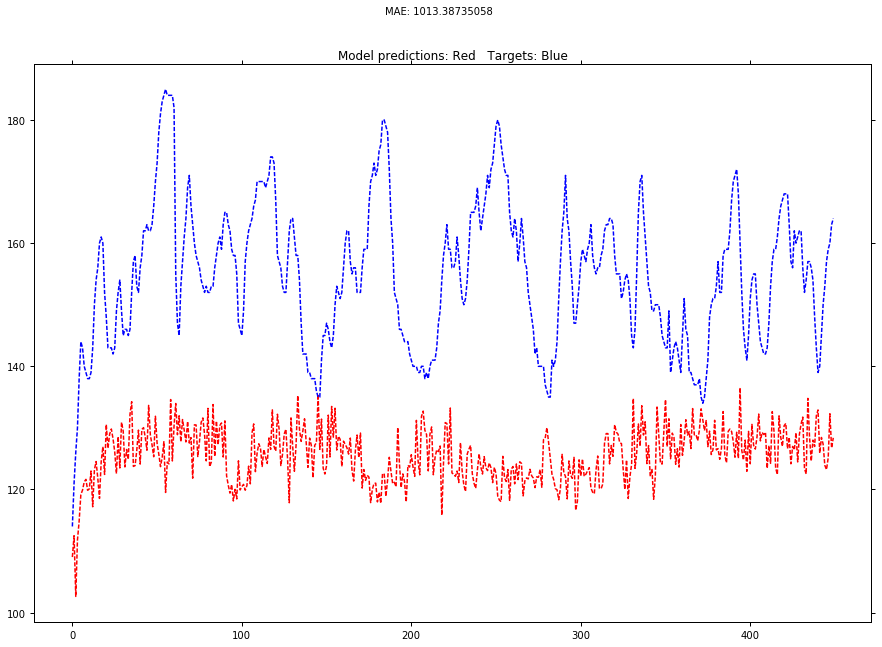

In [13]:
(rawinputs, rawtargets) = endoIter.next()
targets = rawtargets[0]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    predictions, hidden = model.sample(num_steps)
error = seqMSE(predictions, targets)

indices=np.array(range(num_steps))
plt.figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
plt.plot(indices, predictions, 'r--', indices, 
         targets, 'b--')
plt.title("Model predictions: Red   Targets: Blue")
plt.suptitle("MAE: "+ str(error))
plt.show()

# Global-mean baseline

In [ ]:
import time
import datetime
import pickle

trimmed_workout_length=450
batch_size=1
num_steps=trimmed_workout_length
trainValTestSplit=(.9, 0,.1)
predictions_fn = "heart_rate_global_mean_baseline"


modelRunIdentifier = datetime.datetime.now().strftime("%I_%M%p_%B_%d_%Y")

#Compute on new metadata with excised data removed
endoReader_2=dataInterpreter(fn="../multimodalDBM/endomondoHR_proper.json", allowMissingData=True, scaleVals=False, trimmed_workout_length=trimmed_workout_length)
endoReader_2.buildDataSchema(["sport", "heart_rate","gender", "altitude", "time_elapsed", "distance"], "heart_rate", trainValTestSplit=trainValTestSplit)
test_gen = endoReader_2.endoIteratorSupervised(batch_size, num_steps, 'test')


heart_rate_mean = endoReader_2.variableMeans["heart_rate"]
#dspeed_mean = endoReader_2.variableMeans["derived_speed"]


def compute_global_mean_error(global_mean, data_gen):
    test_scores = []
    for i, (inputs, targets) in enumerate(data_gen):
        if i%1000 == 0:
            print("Mean baseline computed on " + str(i) + " workouts so far")
        test_scores.append(np.mean(np.square(np.subtract(heart_rate_mean, targets[0]))))
    return test_scores

test_scores = compute_global_mean_error(heart_rate_mean, test_gen)

#Save test scores
with open(predictions_fn+modelRunIdentifier+".p", "wb") as f:
    pickle.dump(test_scores, f)
    
print("MAE using global mean HR as a baseline " + str(np.mean(test_scores)))
        
        

# Workout Mean Baseline

In [ ]:
import time
import datetime
import pickle

trimmed_workout_length=450
batch_size=1
num_steps=trimmed_workout_length
trainValTestSplit=(0, 0, 1)
predictions_fn = "heart_rate_global_mean_baseline"


modelRunIdentifier = datetime.datetime.now().strftime("%I_%M%p_%B_%d_%Y")

#Compute on new metadata with excised data removed
endoReader_2=dataInterpreter(fn="../multimodalDBM/endomondoHR_proper.json", allowMissingData=True, scaleVals=False, trimmed_workout_length=trimmed_workout_length)
endoReader_2.buildDataSchema(["sport", "heart_rate","gender", "altitude", "time_elapsed", "distance"], "heart_rate", trainValTestSplit=trainValTestSplit)
test_gen = endoReader_2.endoIteratorSupervised(batch_size, num_steps, 'test')


def compute_workout_mean_error(data_gen):
    test_scores = []
    for i, (inputs, targets) in enumerate(data_gen):
        if i%1000 == 0:
            print("Workout mean baseline computed on " + str(i) + " workouts so far")
            workout_mean = np.mean(targets[0])
        test_scores.append(np.mean(np.square(np.subtract(workout_mean, targets[0]))))
    return test_scores

test_scores = compute_workout_mean_error(test_gen)

#Save test scores
with open(predictions_fn+modelRunIdentifier+".p", "wb") as f:
    pickle.dump(test_scores, f)
    
print("MAE using workout mean HRs as a baseline " + str(np.mean(test_scores)))
        
        

# Linear Baseline

In [9]:
(inputs, targets) = endoIter.next()
targets

array([[[ 104.],
        [ 104.],
        [ 109.],
        [ 112.],
        [ 117.],
        [ 121.],
        [ 125.],
        [ 128.],
        [ 130.],
        [ 130.],
        [ 132.],
        [ 133.],
        [ 134.],
        [ 138.],
        [ 137.],
        [ 136.],
        [ 134.],
        [ 128.],
        [ 125.],
        [ 121.],
        [ 123.],
        [ 120.],
        [ 115.],
        [ 112.],
        [ 108.],
        [ 111.],
        [ 115.],
        [ 119.],
        [ 120.],
        [ 121.],
        [ 124.],
        [ 128.],
        [ 130.],
        [ 133.],
        [ 136.],
        [ 137.],
        [ 137.],
        [ 137.],
        [ 137.],
        [ 134.],
        [ 136.],
        [ 136.],
        [ 137.],
        [ 137.],
        [ 137.],
        [ 137.],
        [ 138.],
        [ 138.],
        [ 137.],
        [ 137.],
        [ 137.],
        [ 138.],
        [ 139.],
        [ 137.],
        [ 138.],
        [ 138.],
        [ 142.],
        [ 144.],
        [ 145.